# Exploratory analysis: Yields data

This notebook is for exploring different yield datasets and visualizing relationships between yield, rainfall, and water stress.

- [Figures that work](#another_cell)
- [Figures that dont work](#another_cell2)


Extra credit: Add parameters to legend like bottom of this doc: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

Last updated: 18 May 2020

## Imports

In [1]:
# import packages and set working directory
import numpy as np
import matplotlib.pyplot as plt
import os
from math import exp
import pandas as pd
import seaborn as sns
import proplot as plot
import sys
from scipy.stats import t
from scipy.optimize import curve_fit
import time
import progressbar

# We need to add the module path to our system path so 
# that our notebook can find our local objects and code:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import *

# set background color
plot.rc['figure.facecolor'] = 'white'
plot.rc.axesfacecolor = 'white'

## Functions

Space to play with functions if needed

In [21]:
def total_rf_corr(n_sim = 1000, station = 'OL JOGI FARM', texture = 'loam', lgp=180, pd_sim=100): 
    """ Run simulations for a specific climate, soil, and crop.

    Usage: total_rf_corr(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 500 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    n_sim = n_sim # change back to 1000 later
    planting_date = pd_sim 

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
    
    # Part 4. Run the actual simulations
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 5. Subset the growing period and get avg stress, total rf
    start = 21 
    end = start + lgp
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    total_stress = [df[start:end]['stress'].sum() for df in output]
    
    total_rf = [df[start:end]['R'].sum() for df in output]
    print(total_rf)

    return output, avg_stress, total_stress, total_rf

## Analysis

<a id='another_cell'></a>
### 1. Yield vs. DTM relationship using RidgeToReef Hybrid yields dataset

0.8821342568671494
m 38.209721942492855
b -2572.222327532072


<Figure size 500x400 with 0 Axes>

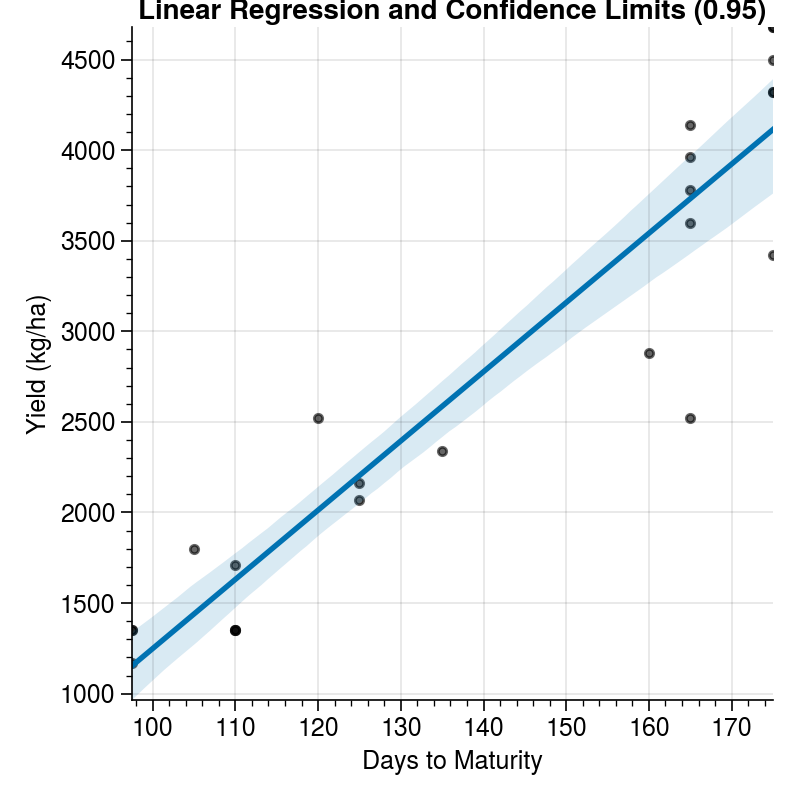

In [2]:
hybrid_data = pd.read_csv('../data/Yields/hybrid_yields.csv')

plot_lin_regression(hybrid_data.days_to_maturity, hybrid_data.yield_kg_ha, 'days_to_maturity', 'yield_kg_ha', hybrid_data,'Days to Maturity', 'Yield (kg/ha)', 
                    'Linear Regression and Confidence Limits (0.95)', positive=False)

### 2. Linear Regression: Seasonal rainfall and stress and yield 

In [4]:
output, avg_stress, total_stress, total_rf = total_rf_corr()

data_tuples = list(zip(total_rf, avg_stress))
df = pd.DataFrame(data_tuples, columns=['TotalRF','AvgStress'])

0.7391051600095477
m -0.0006448499618006332
b 0.49737122554910984


<Figure size 500x400 with 0 Axes>

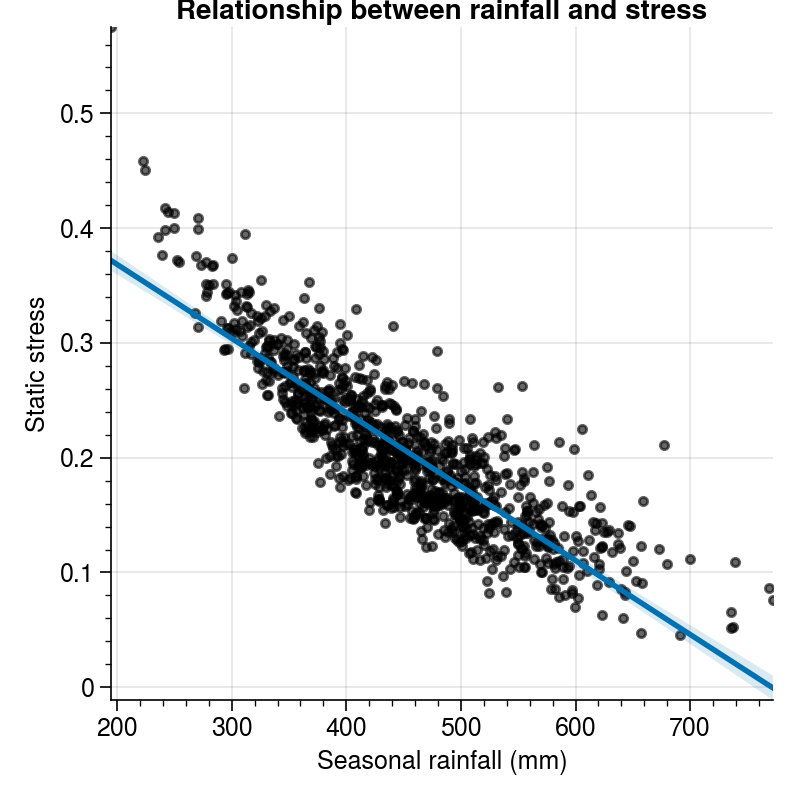

In [5]:
plot_lin_regression(df.TotalRF, df.AvgStress, 'TotalRF','AvgStress',df, 'Seasonal rainfall (mm)', 'Static stress', 'Relationship between rainfall and stress')

#### Play around with dynamic stress

In [3]:
climate = Climate(station='OL JOGI FARM')

soil = Soil(texture='loam')
crop = Crop(soil=soil, lgp=180)
soil.set_nZr(crop)

model = CropModel(crop=crop, climate=climate, soil=soil)
model.run()
o = model.output() # This is the correct length

mstr_memb, dstr_memb, yield_kg_ha = crop.calc_dstress(s=o.s, stress=o.stress) # average stress, dynamic stress, yield

In [6]:
# so this is the stress over a whole season
dstr_memb

# and can be related to an end of season yield
yield_kg_ha

2868.530269732095

In [54]:
def dyn_stress(n_sim = 500, station = 'OL JOGI FARM', texture = 'clay', lgp=180, pd_sim=100): 
    """ Run simulations for a specific climate, soil, and crop.

    Usage: total_rf_corr(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 500 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'clay' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    n_sim = n_sim # change back to 1000 later
    planting_date = pd_sim 

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
    
    # Part 4. Run the actual simulations
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 5. Subset the growing period and get avg stress, total rf
    start = 21 
    end = start + lgp
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    total_stress = [df[start:end]['stress'].sum() for df in output]

    # dont need this but helpful for debugging
    total_rf = [df[start:end]['R'].sum() for df in output]
    avg_s = [df[start:end]['s'].mean() for df in output]

    o = output
    # Part 6. Output the dynamic stress and yield values
    x = [crop.calc_dstress(s=df.s, stress=df.stress) for df in o] #for i in np.arange(n_sim)
    #print(x)
    return  x, total_rf # output, avg_stress, total_stress, total_rf,, mstr_memb, dstr_memb, yield_kg_ha

data, rf = dyn_stress()

In [56]:
rf

[424.793520630359,
 326.7324692981046,
 518.0540812454831,
 379.83984611560845,
 350.4811564703486,
 572.515410146961,
 525.3685793070852,
 430.0097645280407,
 468.8371355796585,
 643.106535618505,
 469.5210263886772,
 399.8484266201191,
 500.5143042448792,
 385.5458811694007,
 461.3708984910857,
 349.6470732392044,
 460.77918861324144,
 392.95727422901103,
 515.1435672483542,
 315.7678761333018,
 616.4496372695759,
 248.04856135819608,
 425.15671109728953,
 543.7300333727617,
 468.6370169647089,
 418.57111119731667,
 461.2678061420618,
 432.101519757398,
 419.01540283996553,
 554.6776909440523,
 408.8780655268176,
 531.7489050246763,
 464.3979792600521,
 486.3343063206315,
 499.96551724550545,
 398.8594765246932,
 576.6505165002327,
 594.4820096513163,
 373.9592919045396,
 330.1099030912393,
 598.349511150413,
 694.9776596292747,
 646.904923224906,
 497.98406148595296,
 448.20885649843456,
 360.4755393558644,
 449.62696608319663,
 536.0994648043192,
 376.49117199659815,
 557.225976302

In [58]:
# when only tuple is the output
df = pd.DataFrame.from_records(data, columns =['AvgStress2','DynamicStress','Yield'])
df
df['RF'] = rf
df

,AvgStress2,DynamicStress,Yield,RF
0,0.281427,0.369897,2684.239344,424.793521
1,0.420340,0.490439,2170.728142,326.732469
2,0.311891,0.395004,2577.283102,518.054081
3,0.366798,0.412497,2502.763765,379.839846
4,0.363659,0.432713,2416.643606,350.481156
...,...,...,...,...
495,0.265499,0.380203,2640.336805,397.972938
496,0.562083,1.000000,0.000000,290.428148
497,0.139743,0.321486,2890.471538,592.459900
498,0.159560,0.313892,2922.821279,721.024559


0.3846148235348855
m 2.836692270229539
b 1304.8935346382198


<Figure size 500x400 with 0 Axes>

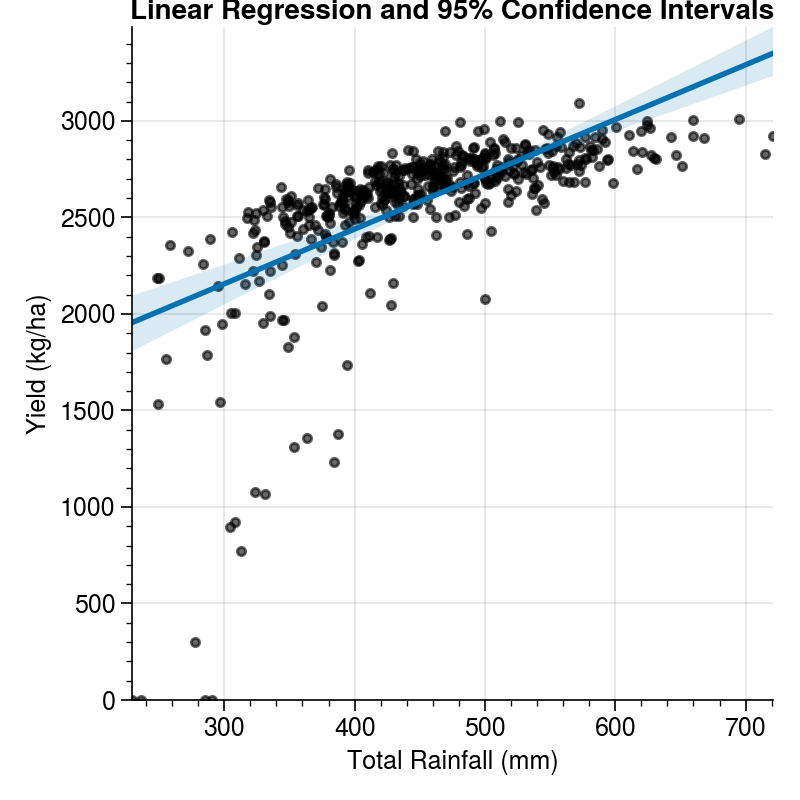

In [59]:
# now do lin regression

plot_lin_regression(df.RF, df.Yield, 'RF', 'Yield',df, 'Total Rainfall (mm)', 'Yield (kg/ha)', 'Linear Regression and 95% Confidence Intervals')
 # whoops that's not what I expected

In [49]:
ds = list(df.DynamicStress)

1.0
m -4259.999999999984
b 4259.999999999994


<Figure size 500x400 with 0 Axes>

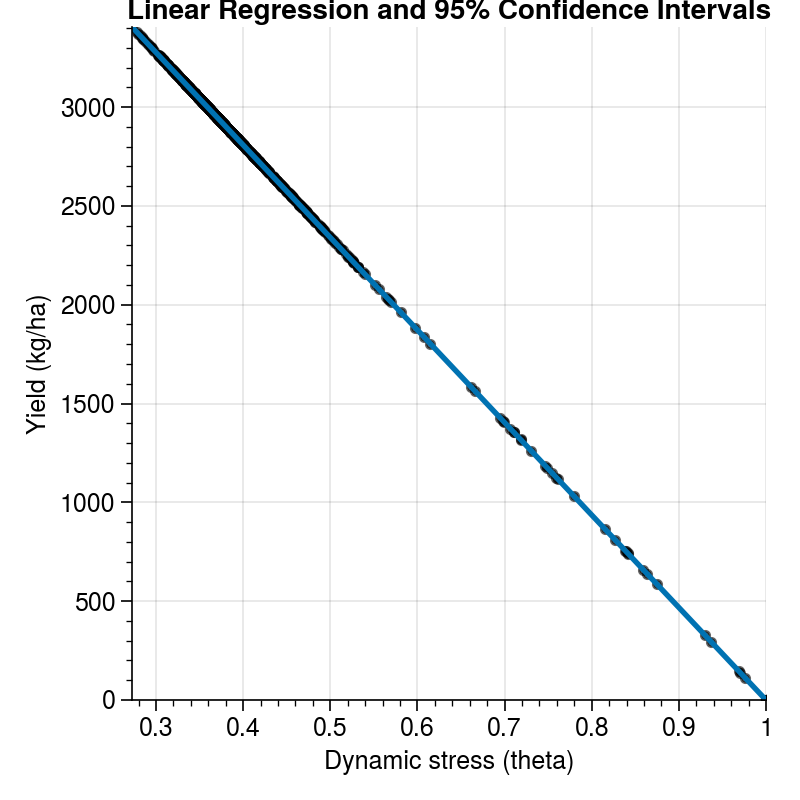

In [50]:
# different yield measure

df['Yield2'] = pd.Series([calc_yield(i) for i in ds])

plot_lin_regression(df.DynamicStress, df.Yield, 'DynamicStress', 'Yield2',df, 'Dynamic stress (theta)', 'Yield (kg/ha)', 'Linear Regression and 95% Confidence Intervals')


In [36]:
#total_stress

# output, avg_stress, total_stress, total_rf, 

#mstr_memb, dstr_memb, yield_kg_ha = dyn_stress()

#data_tuples = list(zip(output, avg_stress, total_stress, total_rf, mstr_memb, dstr_memb, yield_kg_ha))
#df = pd.DataFrame(data_tuples, columns=['TotalRF','AvgStress', 'AvgStress2','DynamicStress','Yield'])

#data_tuples = list(zip(mstr_memb, dstr_memb, yield_kg_ha))
#df = pd.DataFrame(data_tuples, columns=['AvgStress2','DynamicStress','Yield'])


[(0.1856619123478406, 0.33841125318831117, 2818.3680614177943), (0.30600252919196863, 0.40419651517418725, 2538.122845357962), (0.3148709298534436, 0.38786380747912125, 2607.700180138944), (0.3003016664028627, 0.3798837113281995, 2641.6953897418703), (0.38580946209677397, 0.41359496497777576, 2498.0854491946757), (0.34742168226336234, 0.4238399161831601, 2454.441957059738), (0.17547354196518292, 0.3088553846527061, 2944.276061379472), (0.2470973068447368, 0.34741657708263585, 2780.0053816279715), (0.28302017593781154, 0.37263810881738035, 2672.5616564379598), (0.3234437120432891, 0.3960571911702896, 2572.796365614566), (0.47853490453240727, 0.5019615186448384, 2121.643930572988), (0.4337401297697497, 0.9590476202686687, 174.45713765547114), (0.2719972808208105, 0.3624124396854183, 2716.123006940118), (0.2538121030391827, 0.36088834442957457, 2722.6156527300127), (0.39836317897176066, 0.42984604034445806, 2428.8558681326085), (0.3798121560195134, 0.43494426318661517, 2407.137438825019),

ValueError: too many values to unpack (expected 3)

#### Convert stress values to yield

0.7202812464043484
m 2.963099223249397
b 2370.323642533978


4512.55889371052

<Figure size 500x400 with 0 Axes>

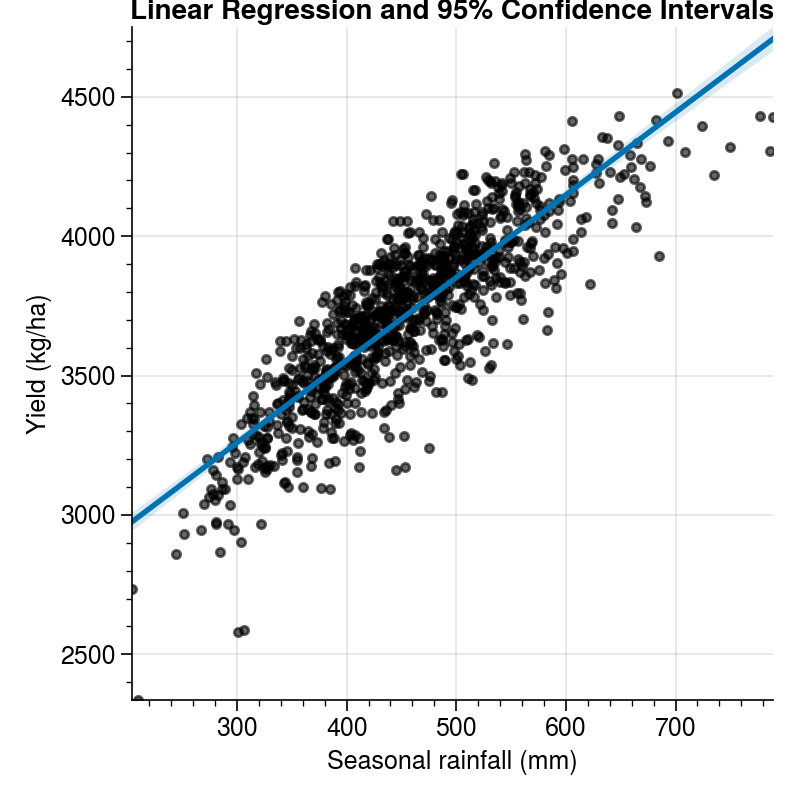

In [6]:
# make a column for yield values from stress
df['Yield'] = pd.Series([calc_yield(i) for i in avg_stress])

plot_lin_regression(df.TotalRF, df.Yield, 'TotalRF', 'Yield',df, 'Seasonal rainfall (mm)', 'Yield (kg/ha)', 'Linear Regression and 95% Confidence Intervals')

max(pd.Series([calc_yield(i) for i in avg_stress]))

#### Try normalizing yields

Kelly's comment: `"Can you normalize yield by max yield? Then we might think about a curve (which will end up being y = ax^c + b, where c is pretty close, but slightly less than 1."`

0.7202812464043484
m 0.0006566339172612991
b 0.5252726221119547


<Figure size 500x400 with 0 Axes>

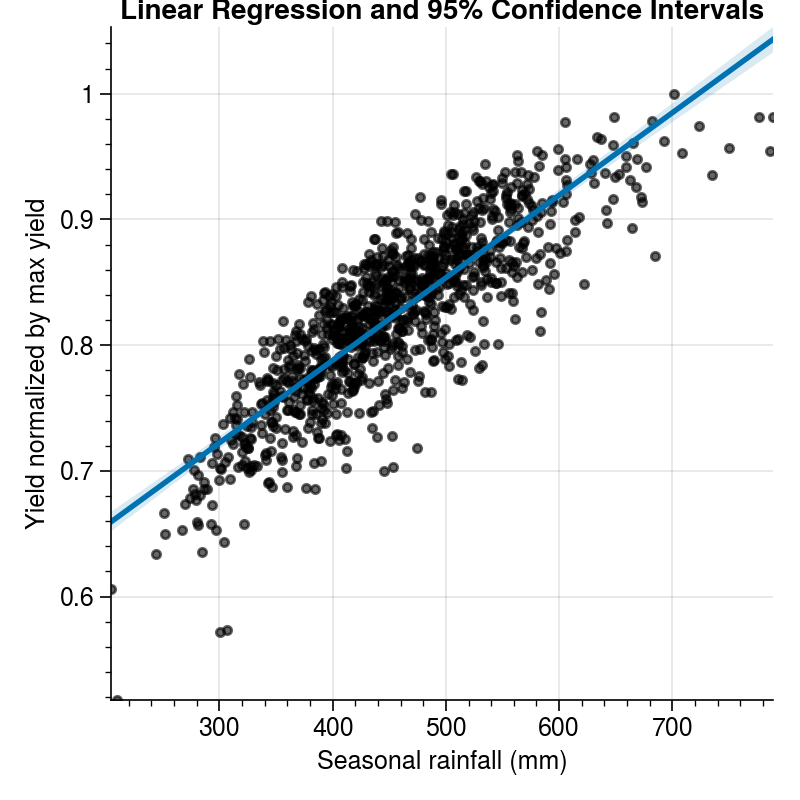

In [7]:
df.TotalRF
df['Yield_norm'] = df.Yield/max(df.Yield)

plot_lin_regression(df.TotalRF, df.Yield_norm, 'TotalRF', 'Yield_norm',df, 'Seasonal rainfall (mm)', 'Yield normalized by max yield', 'Linear Regression and 95% Confidence Intervals')


### 3. Fit curves: Rainfall and yield

#### Polynomial fit

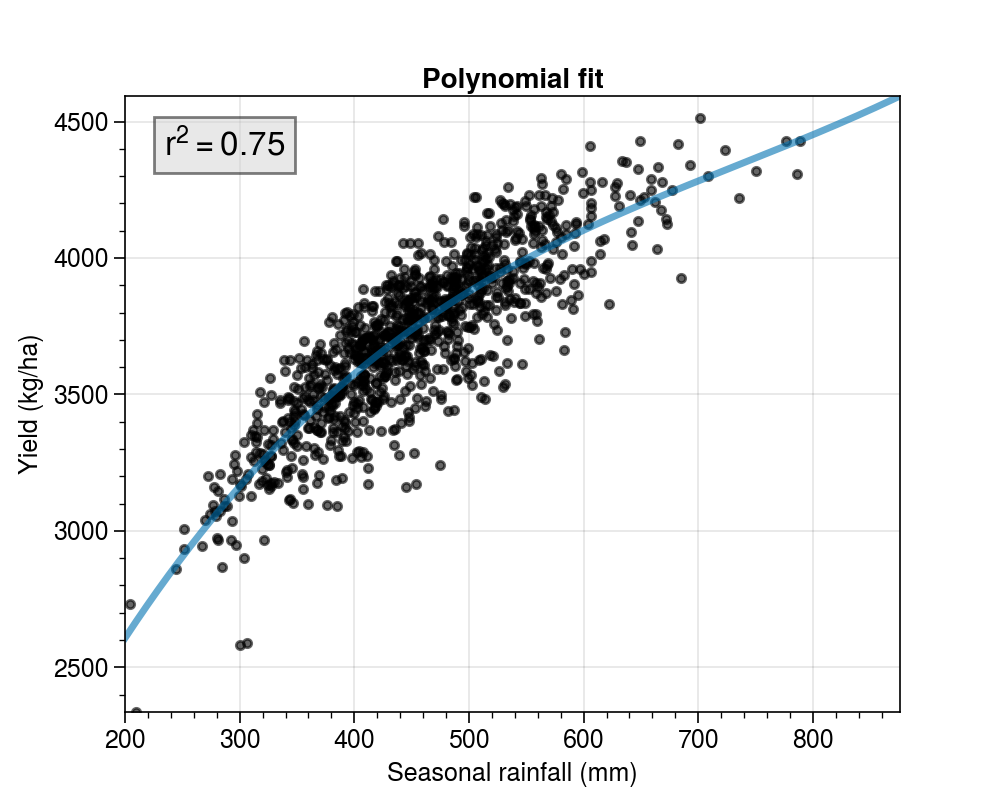

In [8]:
plot_polyfit(x=df.TotalRF, y=df.Yield, degree=2)

#### Power law fit

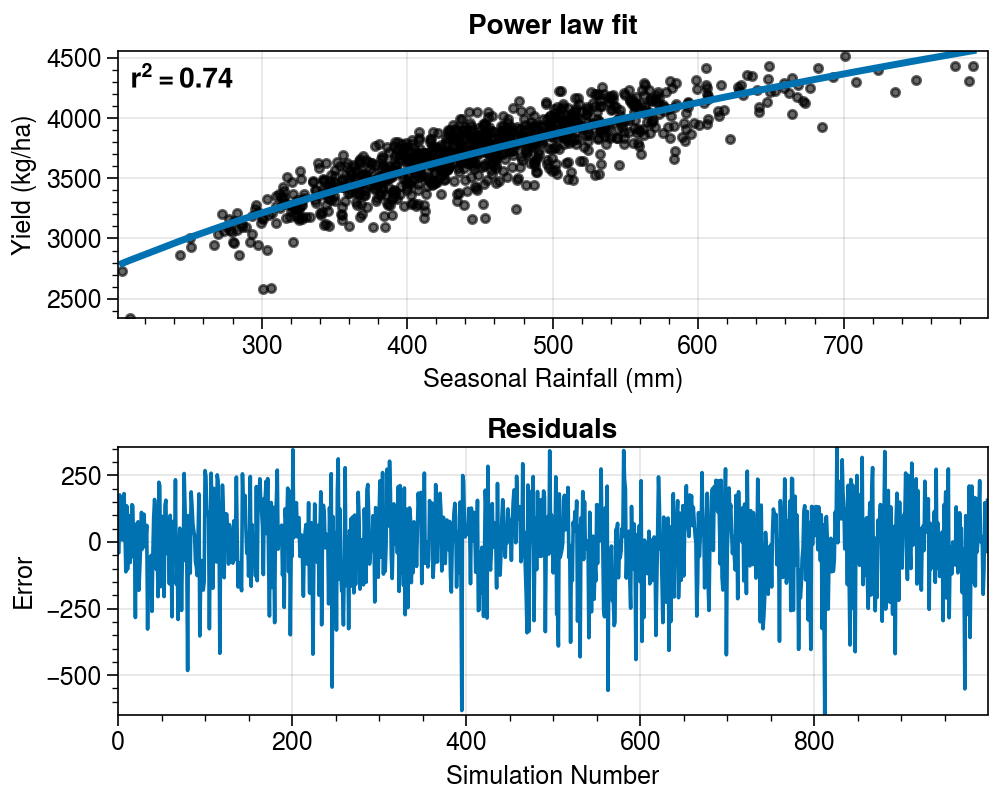

In [9]:
x=df.TotalRF
y=df.Yield

power_law_fit(x,y,'Seasonal Rainfall (mm)', 'Yield (kg/ha)', 'Power law fit')

# confidence intervals around line?

### 4. Update hybrid yields datasets

0.804031087976912
m 27.790555171045057
b -827.7162088258365


<Figure size 500x400 with 0 Axes>

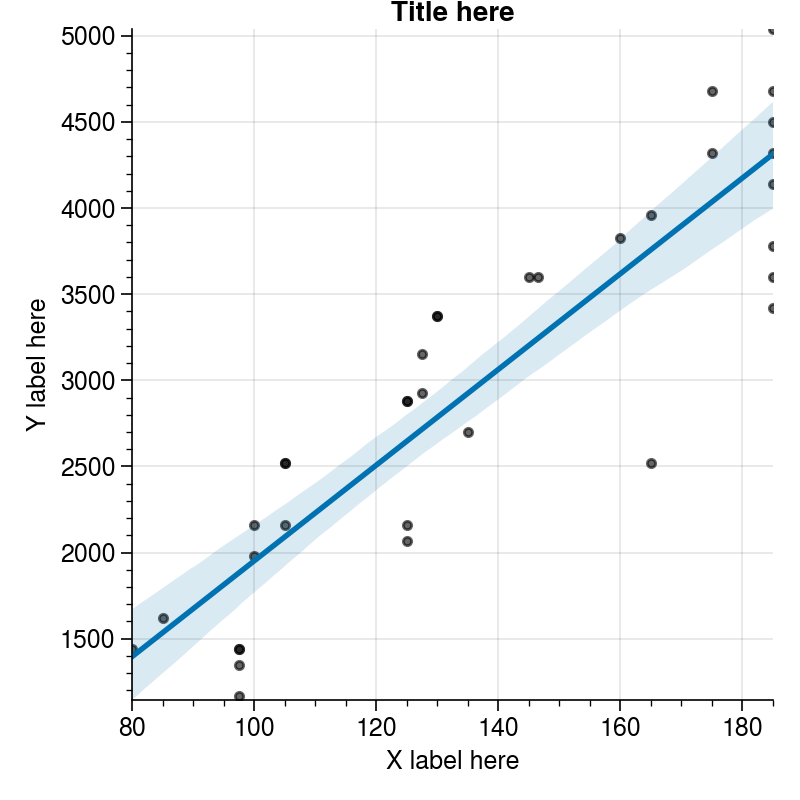

In [10]:
hybrid_data = pd.read_csv('../data/Yields/hybrid_yields_v2.csv', usecols = ['VARIETY','Yield_kg','DTM_Avg']).dropna()

hybrid_data
plot_lin_regression(hybrid_data.DTM_Avg, hybrid_data.Yield_kg, 'DTM_Avg','Yield_kg', hybrid_data)


Some thoughts on how to make these plots prettier:
- Black dots, gray error bars, blue line; [example](https://www.google.com/imgres?imgurl=https%3A%2F%2Fi.stack.imgur.com%2FNhMqj.jpg&imgrefurl=https%3A%2F%2Fstats.stackexchange.com%2Fquestions%2F85560%2Fshape-of-confidence-interval-for-predicted-values-in-linear-regression&tbnid=acETO_fACZOFqM&vet=12ahUKEwjSqOOLhY7pAhXnJjQIHSRSBLQQMygDegUIARDxAQ..i&docid=KblJqW3FklqejM&w=1668&h=993&q=confidence%20intervals%20linear%20regression%20python&ved=2ahUKEwjSqOOLhY7pAhXnJjQIHSRSBLQQMygDegUIARDxAQ).
- Nice example of docstrings for functions; [example](https://gist.github.com/rsnemmen/f2c03beb391db809c90f) or a shorter one [example](https://gist.github.com/rsnemmen/0eb32832c657c19e4d39).
- How to get different kinds of curves, but in R; [example](https://stats.idre.ucla.edu/r/faq/how-can-i-explore-different-smooths-in-ggplot2/)
- Maybe worth knowing the difference between lmplot and regplot in seaborn; [example](https://stackoverflow.com/questions/35948995/seaborn-lmplot-got-an-unexpected-keyword-argument-figsize)

### 5. New regression figure with multiple DTMs

<a id='another_cell2'></a>

x-axis = average water stress \\
y-axis = average yield

In [28]:
result = []

#varieties = np.arange(70,220,5)
varieties = [75, 90, 120, 140, 190, 210]

for i in varieties:
    
    output, avg_stress, total_stress, total_rf = total_rf_corr(n_sim = 500, station = 'OL JOGI FARM', texture = 'loam', lgp=i, pd_sim=100)
    data_tuples = list(zip(total_rf, total_stress, avg_stress))
    df = pd.DataFrame(data_tuples, columns=['TotalRF','TotalStress','AvgStress'])
    df['DTM'] = i
    result.append(df)
    
result = pd.concat(result)

In [29]:
# oops need this step
result = result.reset_index()
result

,index,TotalRF,TotalStress,AvgStress,DTM
0,0,275.720189,4.860500,0.064807,75
1,1,59.999422,23.832327,0.317764,75
2,2,380.678283,0.651218,0.008683,75
3,3,202.233188,15.610924,0.208146,75
4,4,198.027398,6.805104,0.090735,75
...,...,...,...,...,...
2995,495,493.885510,48.586617,0.231365,210
2996,496,511.560328,42.328193,0.201563,210
2997,497,553.622289,41.904594,0.199546,210
2998,498,404.185930,61.983587,0.295160,210


#### Brain dump on yield calculation:

- perhaps the problem is that average stress doesn't tell us enough
- What about cumulative stress?
- or stress above some value?
- the sum of stress above some value; maybe we don't worry about crops that are 10 days to maturity; or write this in as an exception
- or we could force lgp to be between certain values
- back to this idea though... it could be stress values above something? see what other papers did. but i dont feel like you can convert that to yield.

- Kelly's previous idea: Yield = stress^q: 
    1. Current equation: yield_kg_ha = -max_yield*stress + max_yield
    2. Drew’s: Y = Ymax(1-theta)

1. Should we just calculate dynamic stress like Drew did? If not, why not?

In [30]:
# add yield column
result['Yield'] = pd.Series([calc_yield(i) for i in result['AvgStress']])
result

,index,TotalRF,TotalStress,AvgStress,DTM,Yield
0,0,275.720189,4.860500,0.064807,75,4376.704810
1,1,59.999422,23.832327,0.317764,75,3192.862817
2,2,380.678283,0.651218,0.008683,75,4639.363991
3,3,202.233188,15.610924,0.208146,75,3705.878369
4,4,198.027398,6.805104,0.090735,75,4255.361539
...,...,...,...,...,...,...
2995,495,493.885510,48.586617,0.231365,210,3597.212540
2996,496,511.560328,42.328193,0.201563,210,3736.685992
2997,497,553.622289,41.904594,0.199546,210,3746.126192
2998,498,404.185930,61.983587,0.295160,210,3298.651491


In [31]:
# add categorical values for early, med, late
# There is probably a way more efficient way to do this
def category(x):
    if x < 120:
        return "Early"
    if 120 <= x <= 165:
        return "Medium"
    else:
        return "Late"
    
for row in result.DTM:
    result['Category'] = result.DTM.apply(lambda x: category(x))


Text(0.5, 1.0, 'Relationship between rainfall vs. yield of early, medium, late varieties')

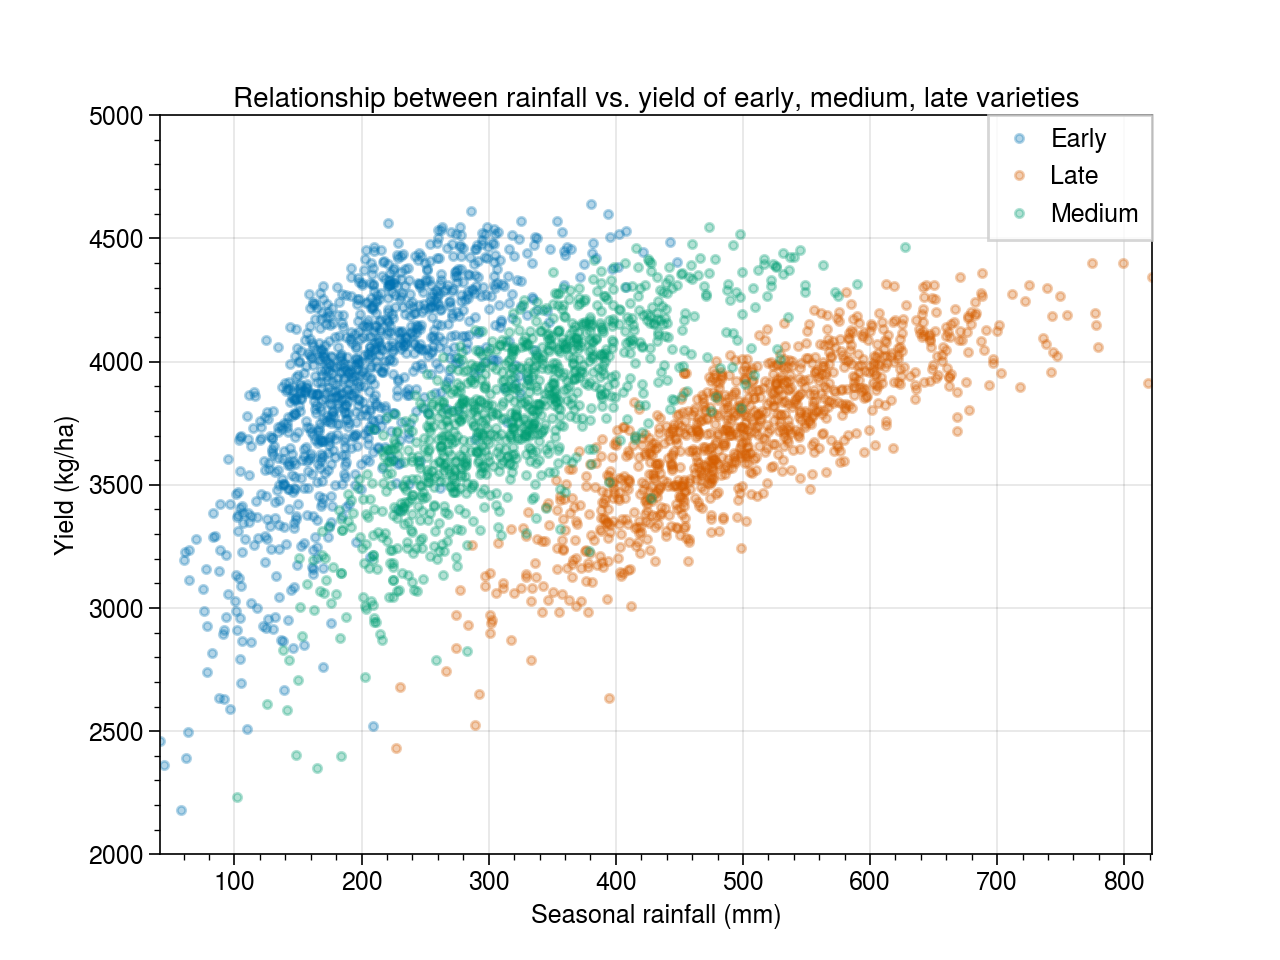

In [32]:
groups = result.groupby("Category")
for name, group in groups:
    plt.plot(group["TotalRF"], group["Yield"], marker="o", linestyle="", label=name, alpha=0.3)
plt.legend()

plt.xlabel('Seasonal rainfall (mm)')
plt.ylabel('Yield (kg/ha)')
plt.ylim(2000,5000)
plt.title('Relationship between rainfall vs. yield of early, medium, late varieties')

Text(0.5, 1.0, 'Relationship between total stress vs. yield of early, medium, late varieties')

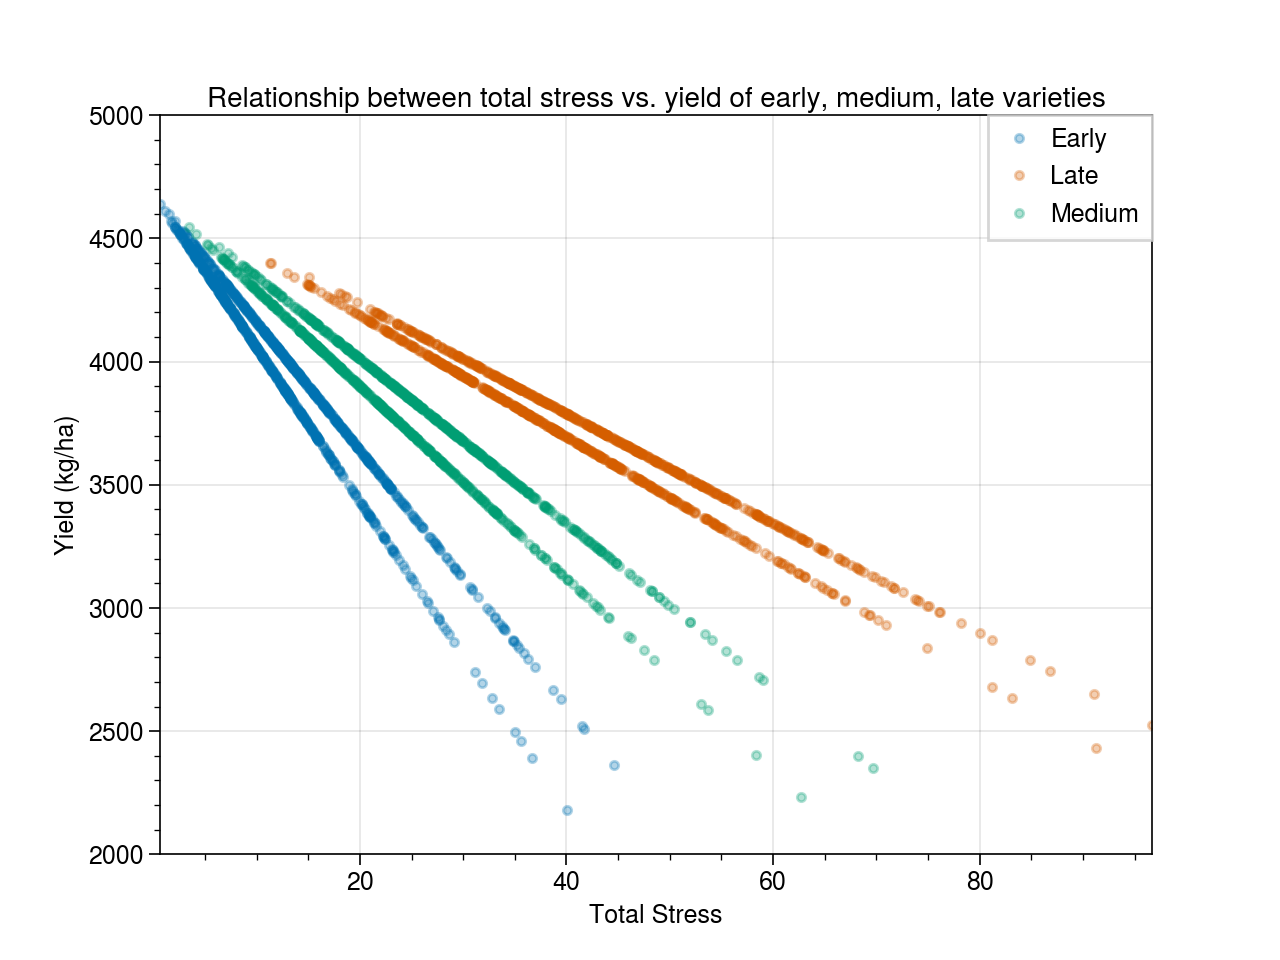

In [33]:
grouped_df = result.groupby("Category")
for key, item in grouped_df:
    plt.plot(item["TotalStress"], item["Yield"], marker="o", linestyle="", label=key, alpha=0.3)
    #print(grouped_df.get_group(key), "\n\n")
plt.legend()

plt.xlabel('Total Stress')
plt.ylabel('Yield (kg/ha)')
plt.ylim(2000,5000)
plt.title('Relationship between total stress vs. yield of early, medium, late varieties')



     index     TotalRF  TotalStress  AvgStress  DTM        Yield Category
0        0  275.720189     4.860500   0.064807   75  4376.704810    Early
1        1   59.999422    23.832327   0.317764   75  3192.862817    Early
2        2  380.678283     0.651218   0.008683   75  4639.363991    Early
3        3  202.233188    15.610924   0.208146   75  3705.878369    Early
4        4  198.027398     6.805104   0.090735   75  4255.361539    Early
..     ...         ...          ...        ...  ...          ...      ...
995    495  191.540672    19.787083   0.219856   90  3651.071670    Early
996    496  228.904789    14.396627   0.159963   90  3931.375400    Early
997    497  197.711920    16.106481   0.178961   90  3842.462963    Early
998    498  206.335489    28.304239   0.314492   90  3208.179547    Early
999    499  206.012185    15.336640   0.170407   90  3882.494739    Early

[1000 rows x 7 columns] 


      index     TotalRF  TotalStress  AvgStress  DTM        Yield Category
2000     

Text(0.5, 1.0, 'Relationship between average stress vs. yield of early, medium, late varieties')

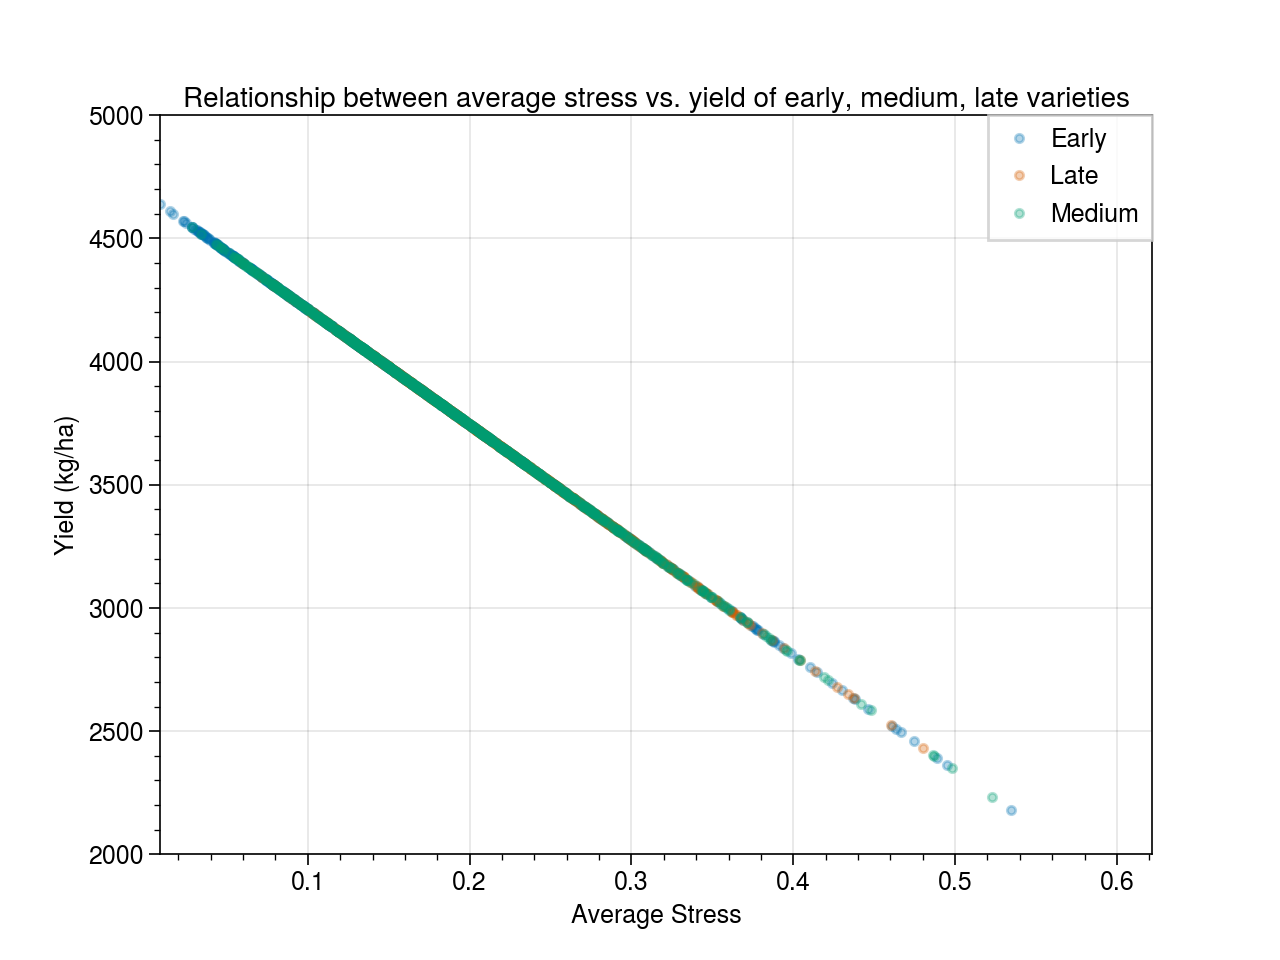

In [34]:
# this actually makes sense because it's the same equation governing the average stress vs. yield relationship
# for all the varieties

grouped_df = result.groupby("Category")
for key, item in grouped_df:
    plt.plot(item["AvgStress"], item["Yield"], marker="o", linestyle="", label=key, alpha=0.3)
    print(grouped_df.get_group(key), "\n\n")
plt.legend()

plt.xlabel('Average Stress')
plt.ylabel('Yield (kg/ha)')
plt.ylim(2000,5000)
plt.title('Relationship between average stress vs. yield of early, medium, late varieties')

Text(0.5, 1.0, 'Relationship between rainfall vs. yield of early, medium, late varieties')

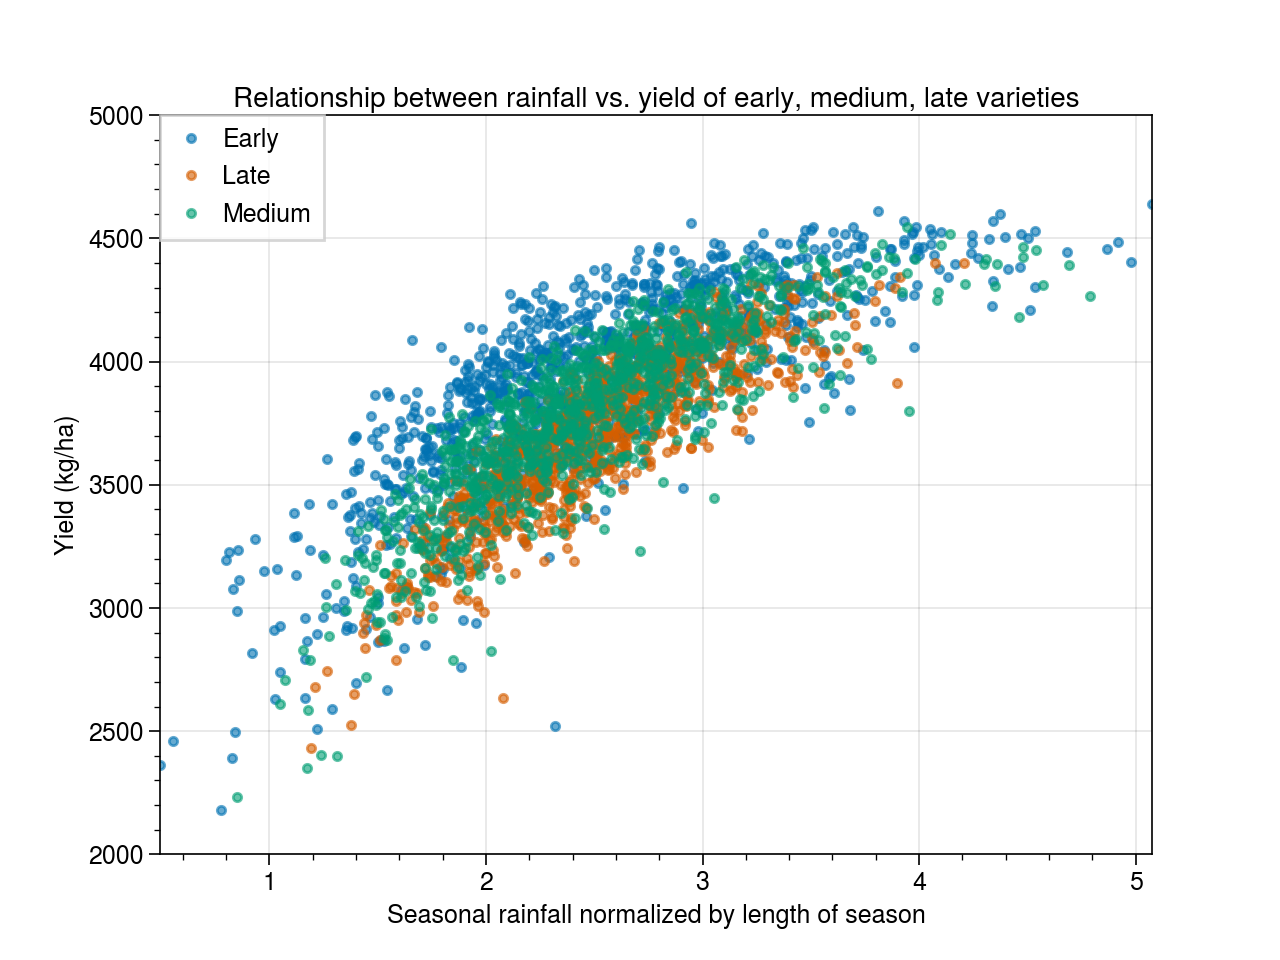

In [35]:
# maybe I need to normalize by length of season
result['TotalRF_norm'] = result['TotalRF']/result['DTM']
result

groups = result.groupby("Category")
for name, group in groups:
    plt.plot(group["TotalRF_norm"], group["Yield"], marker="o", linestyle="", label=name, alpha=0.6)
plt.legend()

plt.xlabel('Seasonal rainfall normalized by length of season')
plt.ylabel('Yield (kg/ha)')
plt.ylim(2000,5000)
plt.title('Relationship between rainfall vs. yield of early, medium, late varieties')


Text(0.5, 1.0, 'Relationship between stress vs. yield of early, medium, late varieties')

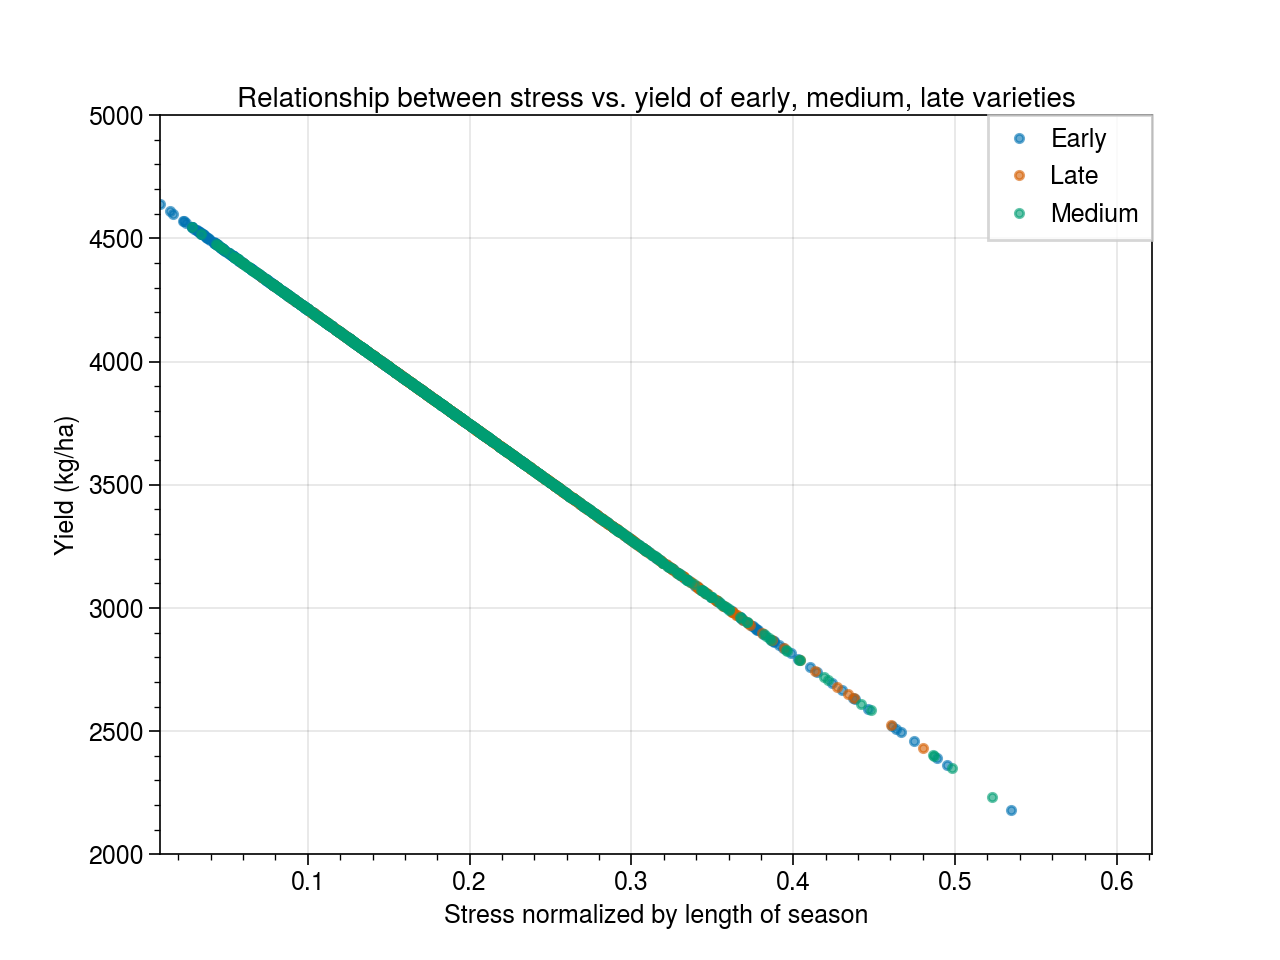

In [36]:
# maybe I need to normalize by length of season
result['TotalStress_norm'] = result['TotalStress']/result['DTM']
result

groups = result.groupby("Category")
for name, group in groups:
    plt.plot(group["TotalStress_norm"], group["Yield"], marker="o", linestyle="", label=name, alpha=0.6)
plt.legend()

plt.xlabel('Stress normalized by length of season')
plt.ylabel('Yield (kg/ha)')
plt.ylim(2000,5000)
plt.title('Relationship between stress vs. yield of early, medium, late varieties')


(2000.0, 5000.0)

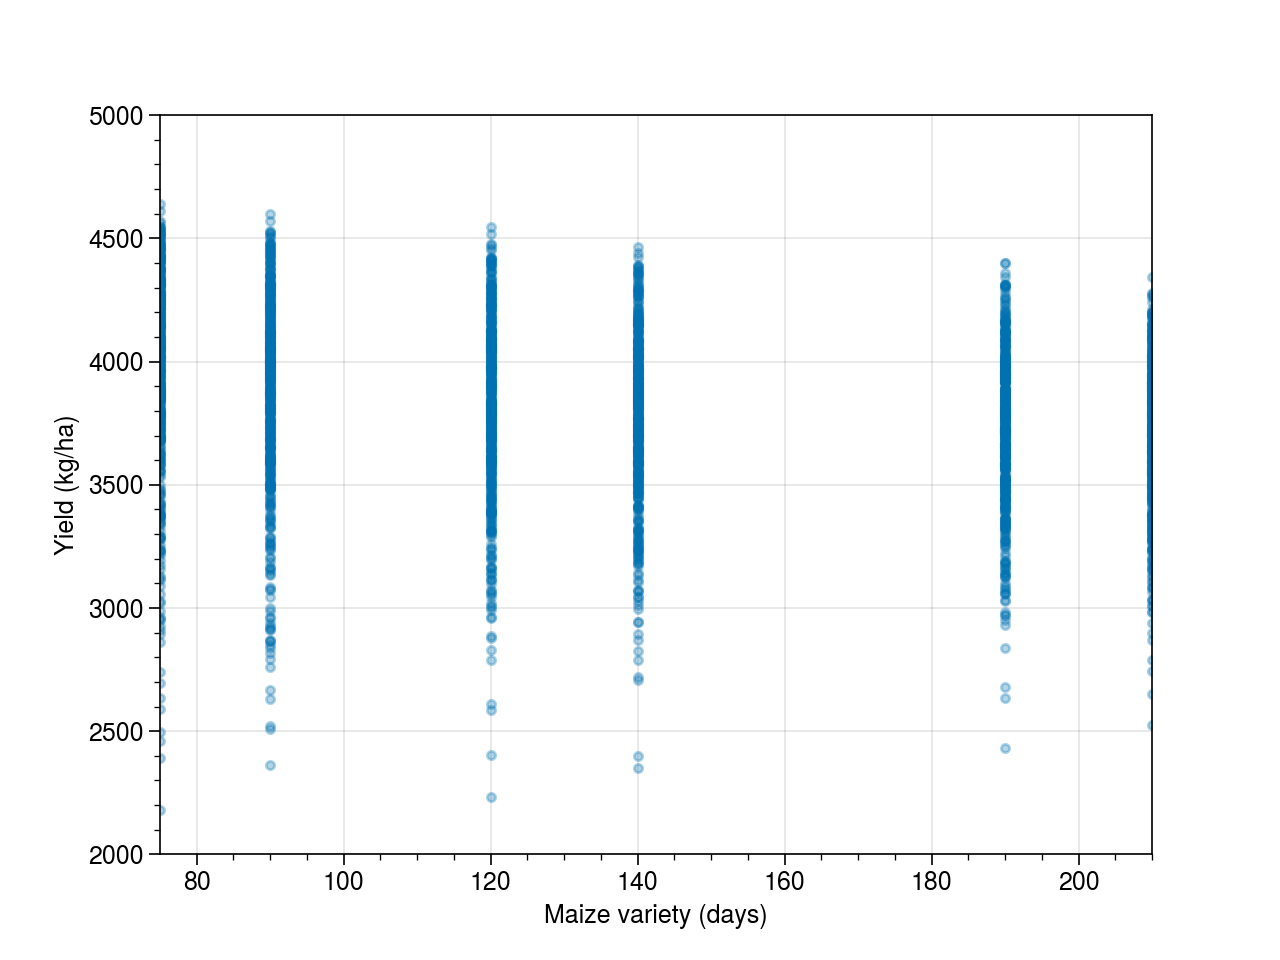

In [37]:
# what if I take lgp as the x-axis? yield as the y-axis?

plt.plot(result["DTM"], result["Yield"], marker="o", linestyle="", label='Category', alpha=0.3)
plt.xlabel('Maize variety (days)')
plt.ylabel('Yield (kg/ha)')
plt.ylim(2000,5000)
#plt.title('Relationship between stress vs. yield of early, medium, late varieties')

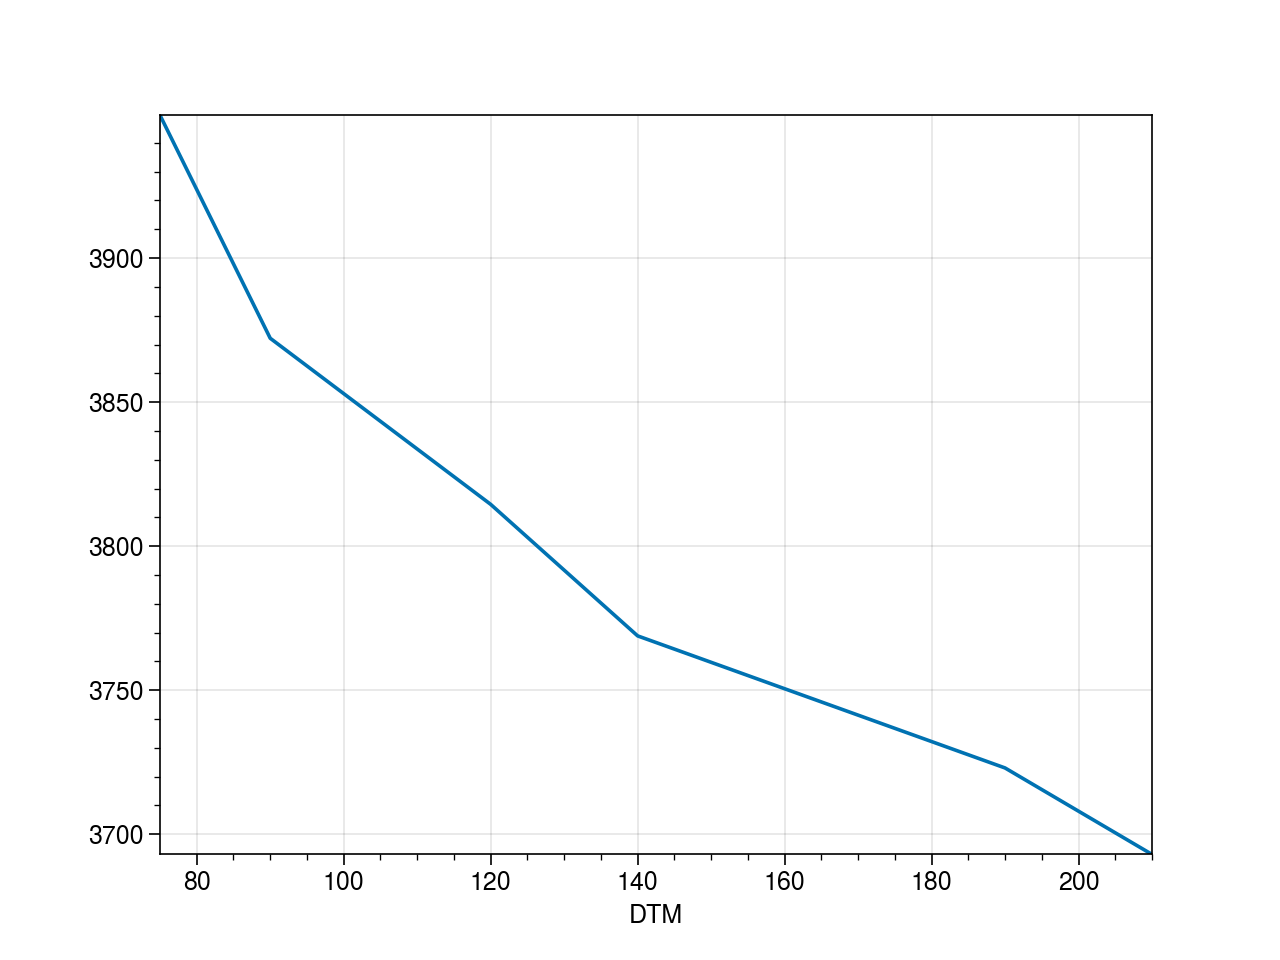

In [51]:
# can I plot the average yield per DTM. How would I do this?
# Houston we have a problem
result

result.groupby('DTM')['Yield'].mean().plot()

# NOTE: new binning to change this figure so that it shows different climatologes 

0.6053759376120946
m 464.55852934209673
b 2639.666832887003


<Figure size 500x400 with 0 Axes>

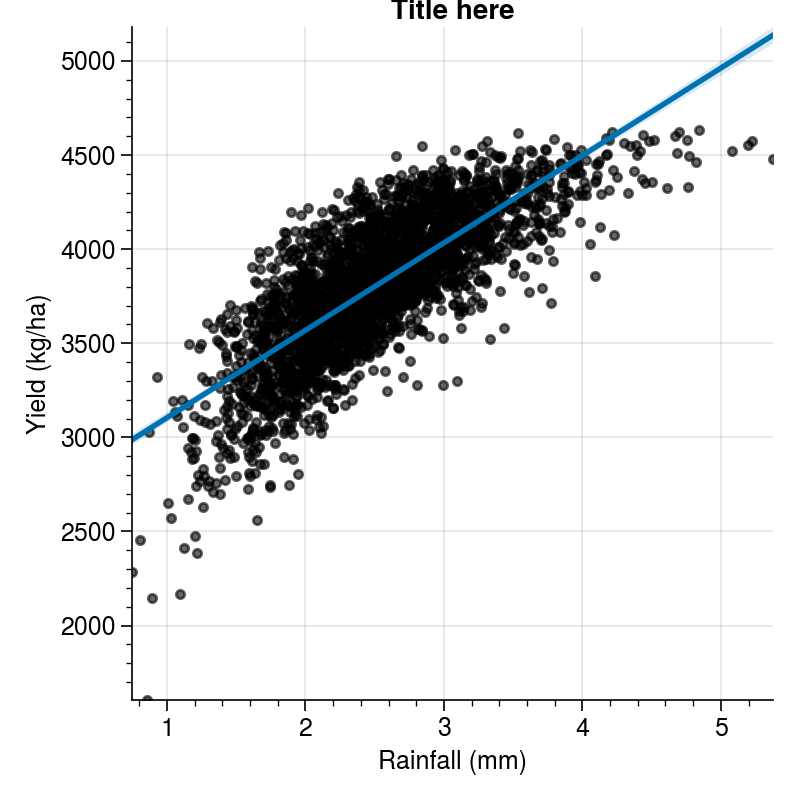

In [22]:
plot_lin_regression(result.TotalRF_norm, result.Yield, 'TotalRF_norm', 'Yield', data = result, 
                        x_lab = 'Rainfall (mm)', y_lab = 'Yield (kg/ha)', title = 'Title here', positive = True)





In [23]:
# what if I use planting date as the x axis value

#import time
#import progressbar
#for i in progressbar.progressbar(range(simulations)):
#    time.sleep(0.02)
        
result = []

#varieties = np.arange(70,220,5)
#varieties = [75, 90, 120, 140, 190, 210]
planting_dates = np.arange(30,230,1)

for i in planting_dates:
    output, avg_stress, total_stress, total_rf = total_rf_corr(n_sim = 50, station = 'OL JOGI FARM', texture = 'loam', lgp=100, pd_sim=i)
    data_tuples = list(zip(total_rf, total_stress, avg_stress))
    df = pd.DataFrame(data_tuples, columns=['TotalRF','TotalStress','AvgStress'])
    df['PD'] = i
    result.append(df)

result = pd.concat(result)


In [24]:
result

,TotalRF,TotalStress,AvgStress,PD
0,355.322747,10.070955,0.100710,30
1,211.586852,20.847507,0.208475,30
2,239.329601,13.313639,0.133136,30
3,173.545638,23.522716,0.235227,30
4,268.461533,15.672316,0.156723,30
...,...,...,...,...
45,240.343921,11.521323,0.115213,229
46,226.472921,16.735265,0.167353,229
47,243.945588,14.027604,0.140276,229
48,276.770927,13.878260,0.138783,229


In [25]:
# add yield column
result['Yield'] = pd.Series([calc_yield(i) for i in df['AvgStress']])
result

# add categorical values for early, med, late
# There is probably a way more efficient way to do this
def category(x):
    if x < 120:
        return "Early"
    if 120 <= x <= 165:
        return "Medium"
    else:
        return "Late"
    
#for row in result.DTM:
#    result['Category'] = result.DTM.apply(lambda x: category(x))


4.440892098500626e-16
m -2.8610944765806645e-14
b 3868.1097116322744


<Figure size 500x400 with 0 Axes>

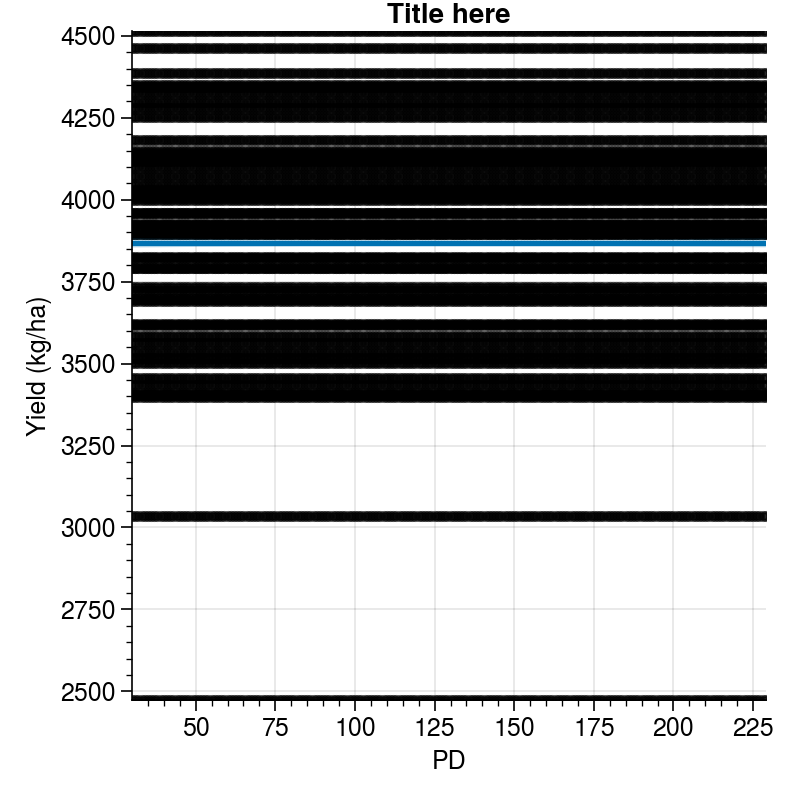

In [26]:
plot_lin_regression(result.PD, result.Yield, 'PD', 'Yield', data = result, 
                        x_lab = 'PD', y_lab = 'Yield (kg/ha)', title = 'Title here', positive = True)



